In [1]:
import pandas as pd
import numpy as np
import mysql.connector
import altair as alt
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
from scipy.stats import ttest_rel
from scipy.stats import shapiro, levene, ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
from urllib.parse import quote_plus
from sqlalchemy_utils import create_database, database_exists
from sqlalchemy import MetaData
import pymysql
from sqlalchemy.orm import Session
from sqlalchemy import Table, Column, Integer, BIGINT, String, BigInteger, Boolean, Float, Unicode
from sqlalchemy import ForeignKey, Text
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.dialects.mysql import LONGTEXT
from sqlalchemy import create_engine

In [2]:
mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="3901",
    database="lotech",
    auth_plugin='mysql_native_password'
)

In [4]:
query = """
select
       products.model_name,
       products.storage,
       order_details.quantity,
       order_details.price,
       order_details.discount,
       category.name,
       cpu.Corei,
       cpu.speed,
       cpu.brand,
       gpu.brand,
       manufacturers.Name,
       screen.size,
       screen.screen_type,
       ram.capacity
from order_details
         inner join orders on order_details.order_id = orders.id
         inner join products on order_details.product_code = products.code
         inner join category on products.category_id = category.id
         inner join cpu on products.CPU_id = cpu.id
         inner join gpu on products.GPU_id = gpu.id
         inner join manufacturers on products.manufacturer_id = manufacturers.id
         inner join screen on products.screen_id = screen.id
         inner join ram on products.RAM_id = ram.id
"""
mycursor = mydb.cursor()
mycursor.execute(query)
orders = mycursor.fetchall()
df_orders = pd.DataFrame(
    orders,
    columns=['model_name', 'storage', 'quantity', 'price', 'discount', 'category_name', 'cpu_Corei', 'cpu_speed', 'cpu_brand',
             'gpu_brand', 'manufacturers', 'screen_size', 'screen_type', 'ram'])

In [5]:
top_products = df_orders.groupby('model_name')['quantity'].sum().sort_values(ascending=False).head(10)
print("Top 10 Selling Products:")
print(top_products)

Top 10 Selling Products:
model_name
Legion Y520-15IKBN    28362
Inspiron 5570         26902
ProBook 450           25633
XPS 13                20669
Inspiron 3567         20419
Inspiron 5567         17532
Latitude 5580         16518
Vostro 3568           16021
Satellite Pro         14848
ProBook 470           13052
Name: quantity, dtype: int64


In [6]:
# ساخت بازه‌های قیمتی
price_bins = [0, 20000000, 40000000, 60000000, 80000000, 100000000, 120000000, float('inf')]
price_labels = ['0-20000000', '20000000-40000000', '40000000-60000000', '60000000-80000000', '80000000-100000000', '100000000-120000000', '120000000+']

In [7]:
# افزودن ستون بازه قیمتی به داده
df_orders['price_range'] = pd.cut(df_orders['price'], bins=price_bins, labels=price_labels)

In [8]:
# تحلیل سلیقه مشتریان بر اساس بازه‌های قیمتی
price_preference = df_orders.groupby('price_range')['quantity'].sum()
print("\nCustomer Preferences Based on Price Ranges:")
print(price_preference)


Customer Preferences Based on Price Ranges:
price_range
0-20000000             858686
20000000-40000000      190655
40000000-60000000       56780
60000000-80000000       14612
80000000-100000000       4074
100000000-120000000      1045
120000000+                587
Name: quantity, dtype: int64


C:\Users\mehrd\AppData\Local\Temp\ipykernel_9948\1627445289.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_preference = df_orders.groupby('price_range')['quantity'].sum()


In [12]:
# تحلیل ترجیح مشتریان به حافظه RAM بر اساس بازه‌های قیمتی
ram_preference = df_orders.groupby(['price_range', 'ram'])['quantity'].sum().unstack()
# ram_preference_df = pd.DataFrame({
#     'index': ram_preference.index,
#     'value': ram_preference.values
# })
ram_preference.to_csv('11-ram-preference.csv', index=False)
# گرافیک برای نمایش نتایج
ram_preference
# ram_preference.plot(kind='bar', stacked=True, title='Customer RAM Preference Based on Price Ranges')
# plt.xlabel('Price Range')
# plt.ylabel('Quantity Sold')
# plt.show()

C:\Users\mehrd\AppData\Local\Temp\ipykernel_9948\2879145451.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ram_preference = df_orders.groupby(['price_range', 'ram'])['quantity'].sum().unstack()


ram,2,4,6,8,12,16,24,32,64
price_range,,,,,,,,,
0-20000000,4550,262046,35270,453523,13626,86329,922,2369,51
20000000-40000000,36,44269,5017,113479,3584,23361,237,667,5
40000000-60000000,0,9460,521,34481,1309,10664,68,260,17
60000000-80000000,0,1232,0,8673,445,3753,82,423,4
80000000-100000000,0,148,0,2077,152,1508,6,176,7
100000000-120000000,0,43,0,436,11,477,2,62,14
120000000+,0,6,0,129,3,200,7,233,9


C:\Users\mehrd\AppData\Local\Temp\ipykernel_14620\1232148441.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ram_preference = df_orders.groupby(['price_range', 'cpu_Corei'])['quantity'].sum().unstack()


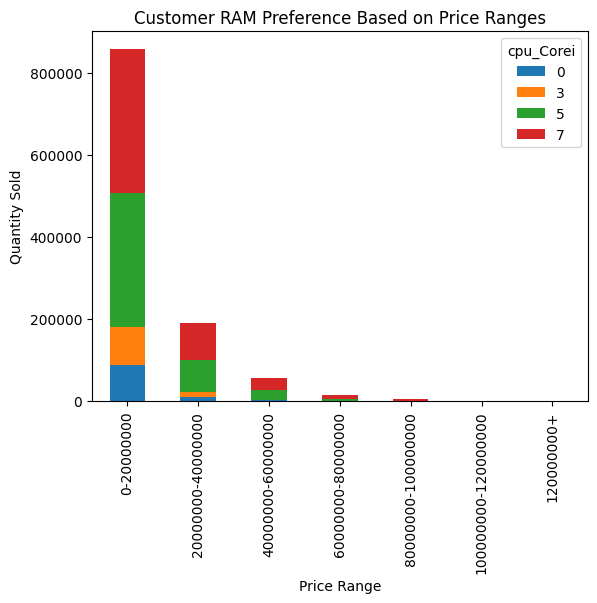

In [25]:
ram_preference = df_orders.groupby(['price_range', 'cpu_Corei'])['quantity'].sum().unstack()

ram_preference.plot(kind='bar', stacked=True, title='Customer RAM Preference Based on Price Ranges')
plt.xlabel('Price Range')
plt.ylabel('Quantity Sold')
plt.show()

C:\Users\mehrd\AppData\Local\Temp\ipykernel_14620\2564554475.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ram_preference = df_orders.groupby(['price_range', 'gpu_brand'])['quantity'].sum().unstack()


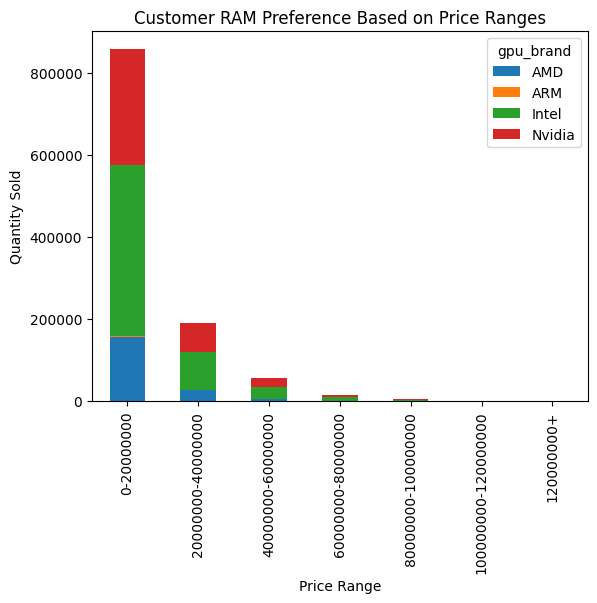

In [26]:
ram_preference = df_orders.groupby(['price_range', 'gpu_brand'])['quantity'].sum().unstack()

ram_preference.plot(kind='bar', stacked=True, title='Customer RAM Preference Based on Price Ranges')
plt.xlabel('Price Range')
plt.ylabel('Quantity Sold')
plt.show()

C:\Users\mehrd\AppData\Local\Temp\ipykernel_14620\1853970204.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ram_preference = df_orders.groupby(['price_range', 'manufacturers'])['quantity'].sum().unstack()


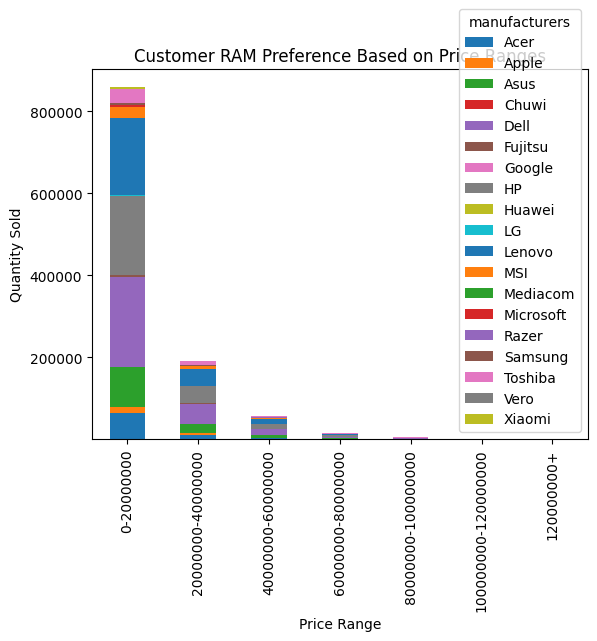

In [27]:
ram_preference = df_orders.groupby(['price_range', 'manufacturers'])['quantity'].sum().unstack()

ram_preference.plot(kind='bar', stacked=True, title='Customer RAM Preference Based on Price Ranges')
plt.xlabel('Price Range')
plt.ylabel('Quantity Sold')
plt.show()

C:\Users\mehrd\AppData\Local\Temp\ipykernel_14620\1178977389.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ram_preference = df_orders.groupby(['price_range', 'screen_size'])['quantity'].sum().unstack()


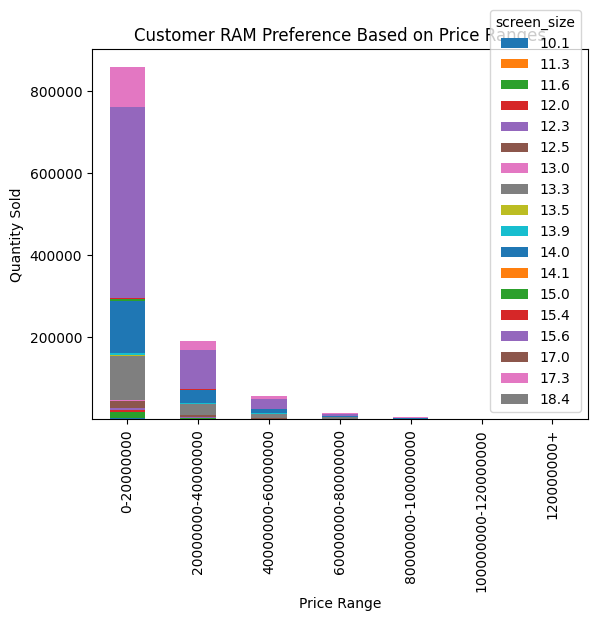

In [29]:
ram_preference = df_orders.groupby(['price_range', 'screen_size'])['quantity'].sum().unstack()

ram_preference.plot(kind='bar', stacked=True, title='Customer RAM Preference Based on Price Ranges')
plt.xlabel('Price Range')
plt.ylabel('Quantity Sold')
plt.show()